# The Main Expermint 1: Sakhaa Alsaedi_157323

## Note!


<ol>
  <li>To save time we provide audmanted images that genrated by CGAN and transforming, the data is attached with code. You need to change direcroty of images</li>
  <li>To get the best performance, you have to train the model on 100 epochs, but in this experiment, we just run it on 1 epoch for running time-consuming.</li>
    <li>Pretrained: Augmented Chest X-ray Images</li>
 
</ol>
 

## Import libraries

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline
import argparse

import random


import torch.nn.parallel
import torch.backends.cudnn as cudnn

import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision
import shutil

from PIL import Image
import PIL

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Using PyTorch version 1.6.0
Random Seed:  999


In [2]:
## Evaluationg model Performnc function 

In [3]:
samples = 100
def find_scores(model, num_images=samples):
    was_training = model.training
    model.eval()
    images_so_far = 0
    correct_preds = 0
    wrong_preds = 0
    TP_0 = 0
    TP_1 = 0
    TP_2 = 0
    TN_0 = 0
    TN_1 = 0
    TN_2 = 0
    FP_0 = 0
    FP_1 = 0
    FP_2 = 0
    FN_0 = 0
    FN_1 = 0
    FN_2 = 0
    TP = 0.00001
    FP = 0.000001
    TN = 0.0000001
    FN = 0.00000001
    con01 = 0
    con02 = 0
    con10 = 0
    con12 = 0
    con20 = 0
    con21 = 0
    precision = 0
    recall = 0
    specificity = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
#                 print(preds)
#                 print(labels)
                for k in range(3):
                    if preds[k] == labels[k]:
                        correct_preds += 1
                    elif preds[k] != labels[k]:
                        wrong_preds += 1
                    if preds[k] == 0 and labels[k] == 0:
                        TP_0 += 1
                    if preds[k] == 1 and labels[k] == 1:
                        TP_1 += 1
                    if preds[k] == 2 and labels[k] == 2:
                        TP_2 += 1
                    if preds[k] != 0 and labels[k] != 0:
                        TN_0 += 1
                    if preds[k] != 1 and labels[k] != 1:
                        TN_1 += 1
                    if preds[k] != 2 and labels[k] != 2:
                        TN_2 += 1
                    if preds[k] == 0 and labels[k] != 0:
                        FP_0 += 1
                    if preds[k] == 1 and labels[k] != 1:
                        FP_1 += 1
                    if preds[k] == 0 and labels[k] != 0:
                        FP_2 += 1
                    if preds[k] != 0 and labels[k] == 0:
                        FN_0 += 1
                    if preds[k] != 1 and labels[k] == 1:
                        FN_1 += 1
                    if preds[k] != 2 and labels[k] == 2:
                        FN_2 += 1
                    if labels[k] == 0 and preds[k] == 1:
                        con01 += 1
                    if labels[k] == 0 and preds[k] == 2:
                        con02 += 1
                    if labels[k] == 1 and preds[k] == 0:
                        con10 += 1
                    if labels[k] == 1 and preds[k] == 2:
                        con12 += 1
                    if labels[k] == 2 and preds[k] == 0:
                        con20 += 1
                    if labels[k] == 2 and preds[k] == 1:
                        con21 += 1
                    
#                 print(correct_preds)
#                 print(wrong_preds)
#                 imshow(inputs.cpu().data[j])
#             print('correct:', correct_preds/(samples*3))
#             print('wrong:', wrong_preds/(samples*3))
            
            TP = TP_0 + TP_1 + TP_2
            FP = FP_0 + FP_1 + FP_2
            TN = TN_0 + TN_1 + TN_2
            FN = FN_0 + FN_1 + FN_2
            
            confusion = np.array([[TP_0,con01,con02],[con10,TP_1,con12],[con20,con21,TP_2]])
            
            precision = TP/(TP+FP)
            recall = TP/(TP+FN)
            specificity = TN/(FP+TN)
            
            F_score = 2*(precision*recall)/(precision+recall)
            
            print('precision:', precision)
            print('recall:', recall)
            print('specificity:', specificity)
            print('F_score:', F_score)
            print('==================Confusion Matrix===================')
            print(confusion)
            if images_so_far == num_images:
                    model.train(mode=was_training)
                    confusion = 0
                    return
            
        model.train(mode=was_training)
#     confusion = np.array([[TP_0,con01,con02],[con10,TP_1,con12],[con20,con21,TP_2]])
#         confusion = 0

# Creating Custom Dataset

In [4]:
class_names = ['normal', 'viral', 'covid']
root_dir = '/ibex/scratch/alsaedsb/COVID_19/Final_Sakhaa/Data/Augmented_Images/'
source_dirs = ['NORMAL', 'Viral_Pneumonia', 'COVID_19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [5]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        
        def get_images(class_name):#pass class name
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')] #get list of image
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name) #get images that belong each class 
            
        self.image_dirs = image_dirs #saveing 
        self.transform = transform #saveing 
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    # the main fuction ( to make balance in the data)
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name]) # to avoide aout of bounds
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name) # return image, lable

# Data augmentation and normalization part

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ColorJitter(brightness=0.4,saturation=0.4,contrast=0.4,hue=0.4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    torchvision.transforms.ToTensor(), #convert image to tensor
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalize image
])


test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])


## Augmanted dataset

In [7]:
train_dirs = {
    'normal': '/ibex/scratch/alsaedsb/COVID_19/Final_Sakhaa/Data/Augmented_Images/train/normal',
    'viral': '/ibex/scratch/alsaedsb/COVID_19/Final_Sakhaa/Data/Augmented_Images/train/viral',
    'covid': '/ibex/scratch/alsaedsb/COVID_19/Final_Sakhaa/Data/Augmented_Images/train/covid'
}

test_dirs = {
    'normal': '/ibex/scratch/alsaedsb/COVID_19/Final_Sakhaa/Data/Augmented_Images/test/normal',
    'viral': '/ibex/scratch/alsaedsb/COVID_19/Final_Sakhaa/Data/Augmented_Images/test/viral',
    'covid': '/ibex/scratch/alsaedsb/COVID_19/Final_Sakhaa/Data/Augmented_Images/test/covid'
}

print('Training Dataset')
train_dataset = ChestXRayDataset(train_dirs, train_transform)
print('Testing Dataset')
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Training Dataset
Found 2511 normal examples
Found 2515 viral examples
Found 1790 covid examples
Testing Dataset
Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


## Data loaders

In [8]:
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test)) #15*6=90


# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")

Number of training batches 54
Number of test batches 1


In [9]:
#Class and Lables

In [10]:

data_transforms = {
    'train': transforms.Compose([
        torchvision.transforms.Resize((64,64)),
        torchvision.transforms.ColorJitter(brightness=0.4,saturation=0.4,contrast=0.4,hue=0.4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
        torchvision.transforms.ToTensor(), #convert image to tensor
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalize image
    ]),
    'test': transforms.Compose([
        torchvision.transforms.Resize(size=(224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(root_dir, x),
                                          data_transforms[x])
                  for x in ['train','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=3,shuffle=True, num_workers=3)
               
              for x in ['train','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','test']}

class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [11]:
class_names

['covid', 'normal', 'viral']

## Visualize Augmented dataset

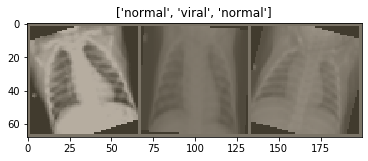

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


# Transfer Learning Part 

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                #phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    #print('Training complete in {:.0f}m {:.0f}s'.format(
        #time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                print(preds)
                print(labels)
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Pretraining the model on ugmanted images

In [17]:
model_pr = models.resnet18(pretrained=False)


In [20]:
num_ftrs = model_pr.fc.in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_pr.fc = nn.Linear(512, 3)
model_pr = model_pr.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_pr = optim.SGD(model_pr.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_pr, step_size=7, gamma=0.1)

## Train and evaluate

In [21]:
model_pr = train_model(model_pr, criterion, optimizer_pr, exp_lr_scheduler,num_epochs=100)
#model_pr = train_model(model_pr, criterion, optimizer_pr, exp_lr_scheduler,num_epochs=1)

Epoch 0/0
----------



In [22]:
find_scores(model_pr)

precision: 1.0
recall: 0.6666666666666666
specificity: 1.0
F_score: 0.8
==================Confusion Matrix===================
[[0 0 0]
 [0 6 3]
 [0 0 0]]
precision: 1.0
recall: 0.8333333333333334
specificity: 1.0
F_score: 0.9090909090909091
==================Confusion Matrix===================
[[ 3  0  0]
 [ 0 12  3]
 [ 0  0  0]]
precision: 0.7777777777777778
recall: 0.7777777777777778
specificity: 0.8888888888888888
F_score: 0.7777777777777778
==================Confusion Matrix===================
[[ 6  0  0]
 [ 0 15  3]
 [ 3  0  0]]
precision: 0.8333333333333334
recall: 0.8333333333333334
specificity: 0.9166666666666666
F_score: 0.8333333333333334
==================Confusion Matrix===================
[[ 9  0  0]
 [ 0 18  3]
 [ 3  0  3]]
precision: 0.7857142857142857
recall: 0.7333333333333333
specificity: 0.896551724137931
F_score: 0.7586206896551724
==================Confusion Matrix===================
[[ 9  0  0]
 [ 0 18  6]
 [ 3  3  6]]
precision: 0.8235294117647058
recall: 0.77777

precision: 0.9126984126984127
recall: 0.9126984126984127
specificity: 0.9563492063492064
F_score: 0.9126984126984127
==================Confusion Matrix===================
[[ 90   0   0]
 [  3 156  15]
 [ 12   3  99]]
precision: 0.9147286821705426
recall: 0.9147286821705426
specificity: 0.9573643410852714
F_score: 0.9147286821705426
==================Confusion Matrix===================
[[ 93   0   0]
 [  3 159  15]
 [ 12   3 102]]
precision: 0.9166666666666666
recall: 0.9166666666666666
specificity: 0.9583333333333334
F_score: 0.9166666666666666
==================Confusion Matrix===================
[[ 96   0   0]
 [  3 162  15]
 [ 12   3 105]]
precision: 0.9185185185185185
recall: 0.9185185185185185
specificity: 0.9592592592592593
F_score: 0.9185185185185185
==================Confusion Matrix===================
[[ 99   0   0]
 [  3 168  15]
 [ 12   3 105]]
precision: 0.9064748201438849
recall: 0.9130434782608695
specificity: 0.9530685920577617
F_score: 0.9097472924187725
===============

precision: 0.8636363636363636
recall: 0.8708333333333333
specificity: 0.9315352697095436
F_score: 0.8672199170124482
==================Confusion Matrix===================
[[159   0   0]
 [ 15 303  27]
 [ 18  33 165]]
precision: 0.8653061224489796
recall: 0.8724279835390947
specificity: 0.9323770491803278
F_score: 0.8688524590163934
==================Confusion Matrix===================
[[162   0   0]
 [ 15 309  27]
 [ 18  33 165]]
precision: 0.8588709677419355
recall: 0.8658536585365854
specificity: 0.9291497975708503
F_score: 0.8623481781376519
==================Confusion Matrix===================
[[165   0   0]
 [ 18 309  30]
 [ 18  33 165]]
precision: 0.8605577689243028
recall: 0.8674698795180723
specificity: 0.93
F_score: 0.864
==================Confusion Matrix===================
[[165   0   0]
 [ 18 318  30]
 [ 18  33 165]]
precision: 0.8622047244094488
recall: 0.8690476190476191
specificity: 0.9308300395256917
F_score: 0.8656126482213439
==================Confusion Matrix========

precision: 0.8812154696132597
recall: 0.8787878787878788
specificity: 0.9406896551724138
F_score: 0.88
==================Confusion Matrix===================
[[261   0   0]
 [ 21 459  48]
 [ 24  39 237]]
precision: 0.8821917808219178
recall: 0.8797814207650273
specificity: 0.9411764705882353
F_score: 0.880984952120383
==================Confusion Matrix===================
[[264   0   0]
 [ 21 465  48]
 [ 24  39 237]]
precision: 0.8831521739130435
recall: 0.8807588075880759
specificity: 0.9416553595658074
F_score: 0.881953867028494
==================Confusion Matrix===================
[[264   0   0]
 [ 21 468  48]
 [ 24  39 243]]
precision: 0.8837837837837837
recall: 0.8790322580645161
specificity: 0.9420485175202157
F_score: 0.8814016172506739
==================Confusion Matrix===================
[[264   0   0]
 [ 21 471  51]
 [ 24  39 246]]
precision: 0.8847184986595175
recall: 0.88
specificity: 0.9425133689839572
F_score: 0.8823529411764706
==================Confusion Matrix===========

precision: 0.9008438818565401
recall: 0.8895833333333333
specificity: 0.950733752620545
F_score: 0.8951781970649896
==================Confusion Matrix===================
[[312   0   6]
 [ 24 618  60]
 [ 24  45 351]]
precision: 0.897489539748954
recall: 0.8881987577639752
specificity: 0.9490114464099896
F_score: 0.8928199791883455
==================Confusion Matrix===================
[[315   0   6]
 [ 24 621  60]
 [ 27  45 351]]
precision: 0.8981288981288982
recall: 0.8888888888888888
specificity: 0.9493278179937953
F_score: 0.8934850051706309
==================Confusion Matrix===================
[[318   0   6]
 [ 24 624  60]
 [ 27  45 354]]
precision: 0.8987603305785123
recall: 0.8895705521472392
specificity: 0.9496402877697842
F_score: 0.8941418293936279
==================Confusion Matrix===================
[[321   0   6]
 [ 24 630  60]
 [ 27  45 354]]
precision: 0.8991769547325102
recall: 0.8882113821138211
specificity: 0.9498977505112475
F_score: 0.8936605316973415
=================

precision: 0.9021922428330523
recall: 0.8916666666666667
specificity: 0.9513830678960603
F_score: 0.8968985750209557
==================Confusion Matrix===================
[[372   3   9]
 [ 30 789  72]
 [ 30  51 444]]
precision: 0.9025210084033614
recall: 0.8905472636815921
specificity: 0.9515859766277128
F_score: 0.8964941569282137
==================Confusion Matrix===================
[[372   3   9]
 [ 30 792  75]
 [ 30  51 447]]
precision: 0.903010033444816
recall: 0.8910891089108911
specificity: 0.9518272425249169
F_score: 0.8970099667774086
==================Confusion Matrix===================
[[375   3   9]
 [ 30 792  75]
 [ 30  51 453]]
precision: 0.9034941763727121
recall: 0.8916256157635468
specificity: 0.9520661157024793
F_score: 0.8975206611570248
==================Confusion Matrix===================
[[375   3   9]
 [ 30 795  75]
 [ 30  51 459]]
precision: 0.9039735099337748
recall: 0.8921568627450981
specificity: 0.9523026315789473
F_score: 0.8980263157894737
================

precision: 0.8951841359773371
recall: 0.8851540616246498
specificity: 0.9478873239436619
F_score: 0.8901408450704226
==================Confusion Matrix===================
[[429   3  12]
 [ 39 906  84]
 [ 33  75 561]]
precision: 0.8956276445698167
recall: 0.8856345885634589
specificity: 0.9481065918653576
F_score: 0.8906030855539971
==================Confusion Matrix===================
[[432   3  12]
 [ 39 912  84]
 [ 33  75 561]]
precision: 0.8960674157303371
recall: 0.8861111111111111
specificity: 0.9483240223463687
F_score: 0.8910614525139664
==================Confusion Matrix===================
[[432   3  12]
 [ 39 918  84]
 [ 33  75 564]]
precision: 0.8938547486033519
recall: 0.8852005532503457
specificity: 0.9471855455177206
F_score: 0.8895066018068103
==================Confusion Matrix===================
[[435   3  12]
 [ 42 918  84]
 [ 33  75 567]]
precision: 0.8929068150208623
recall: 0.8842975206611571
specificity: 0.946712802768166
F_score: 0.8885813148788928
================

precision: 0.9001218026796589
recall: 0.892512077294686
specificity: 0.9502728926622195
F_score: 0.8963007883565798
==================Confusion Matrix===================
[[ 504    9   12]
 [  45 1056   87]
 [  33   81  657]]
precision: 0.9004854368932039
recall: 0.8929001203369434
specificity: 0.950453172205438
F_score: 0.8966767371601209
==================Confusion Matrix===================
[[ 507    9   12]
 [  45 1062   87]
 [  33   81  657]]
precision: 0.9008464328899637
recall: 0.8932853717026379
specificity: 0.950632149307646
F_score: 0.897049969897652
==================Confusion Matrix===================
[[ 510    9   12]
 [  45 1062   87]
 [  33   81  663]]
precision: 0.9012048192771084
recall: 0.8936678614097969
specificity: 0.9508098380323935
F_score: 0.8974205158968206
==================Confusion Matrix===================
[[ 513    9   12]
 [  45 1065   87]
 [  33   81  666]]
precision: 0.9015606242496998
recall: 0.8940476190476191
specificity: 0.9509862522414824
F_score: 0.

precision: 0.902465166130761
recall: 0.8938428874734607
specificity: 0.9514666666666667
F_score: 0.8981333333333333
==================Confusion Matrix===================
[[ 588    9   12]
 [  48 1188   99]
 [  36   96  750]]
precision: 0.9026737967914439
recall: 0.8931216931216931
specificity: 0.9515957446808511
F_score: 0.8978723404255319
==================Confusion Matrix===================
[[ 588    9   12]
 [  48 1188  102]
 [  36   96  756]]
precision: 0.9028815368196371
recall: 0.8924050632911392
specificity: 0.9517241379310345
F_score: 0.8976127320954906
==================Confusion Matrix===================
[[ 591    9   12]
 [  48 1191  105]
 [  36   96  756]]
precision: 0.9031914893617021
recall: 0.8927444794952681
specificity: 0.9518773135906927
F_score: 0.8979375991538868
==================Confusion Matrix===================
[[ 594    9   12]
 [  48 1197  105]
 [  36   96  756]]
precision: 0.9033970276008493
recall: 0.8920335429769392
specificity: 0.9520042194092827
F_score:

precision: 0.9008662175168431
recall: 0.8888888888888888
specificity: 0.9507648183556405
F_score: 0.8948374760994263
==================Confusion Matrix===================
[[ 639    9   15]
 [  51 1317  123]
 [  45  108  852]]
precision: 0.8993288590604027
recall: 0.8882575757575758
specificity: 0.9499761791329204
F_score: 0.8937589328251548
==================Confusion Matrix===================
[[ 642    9   15]
 [  51 1317  123]
 [  48  108  855]]
precision: 0.8996175908221797
recall: 0.8885741265344664
specificity: 0.9501187648456056
F_score: 0.894061757719715
==================Confusion Matrix===================
[[ 645    9   15]
 [  51 1323  123]
 [  48  108  855]]
precision: 0.899904671115348
recall: 0.8888888888888888
specificity: 0.9502605400284225
F_score: 0.8943628612032212
==================Confusion Matrix===================
[[ 648    9   15]
 [  51 1323  123]
 [  48  108  861]]
precision: 0.9001901140684411
recall: 0.8892018779342723
specificity: 0.9504015115729806
F_score: 

precision: 0.9067944250871081
recall: 0.8943298969072165
specificity: 0.953719723183391
F_score: 0.9005190311418685
==================Confusion Matrix===================
[[ 714    9   15]
 [  51 1461  135]
 [  51  108  948]]
precision: 0.9070373588184187
recall: 0.8946015424164524
specificity: 0.953839516824849
F_score: 0.900776531492666
==================Confusion Matrix===================
[[ 714    9   15]
 [  51 1470  135]
 [  51  108  948]]
precision: 0.9072790294627383
recall: 0.8948717948717949
specificity: 0.9539586919104991
F_score: 0.9010327022375215
==================Confusion Matrix===================
[[ 717    9   15]
 [  51 1473  135]
 [  51  108  951]]
precision: 0.9042277825711821
recall: 0.8934356351236147
specificity: 0.9524013722126929
F_score: 0.8987993138936535
==================Confusion Matrix===================
[[ 717    9   15]
 [  57 1476  135]
 [  51  108  951]]
precision: 0.9044750430292599
recall: 0.8937074829931972
specificity: 0.9525235243798118
F_score: 0

precision: 0.9018987341772152
recall: 0.8941176470588236
specificity: 0.9511618747538401
F_score: 0.8979913351713272
==================Confusion Matrix===================
[[ 792   12   15]
 [  66 1587  141]
 [  57  114 1041]]
precision: 0.9021310181531176
recall: 0.8943661971830986
specificity: 0.9512770137524558
F_score: 0.8982318271119843
==================Confusion Matrix===================
[[ 798   12   15]
 [  66 1587  141]
 [  57  114 1044]]
precision: 0.9023622047244094
recall: 0.8946135831381733
specificity: 0.9513916111328891
F_score: 0.8984711877695022
==================Confusion Matrix===================
[[ 798   12   15]
 [  66 1596  141]
 [  57  114 1044]]
precision: 0.9025923016496465
recall: 0.8948598130841121
specificity: 0.9515056707078607
F_score: 0.8987094251075479
==================Confusion Matrix===================
[[ 804   12   15]
 [  66 1596  141]
 [  57  114 1047]]
precision: 0.9028213166144201
recall: 0.8951048951048951
specificity: 0.9516191962543894
F_score

precision: 0.9027576197387518
recall: 0.8956083513318934
specificity: 0.9515720997470184
F_score: 0.899168774846404
==================Confusion Matrix===================
[[ 855   12   15]
 [  72 1737  150]
 [  60  126 1140]]
precision: 0.9029688631426502
recall: 0.8958333333333334
specificity: 0.9516768842408944
F_score: 0.8993869455463397
==================Confusion Matrix===================
[[ 855   12   15]
 [  72 1743  150]
 [  60  126 1143]]
precision: 0.9018050541516246
recall: 0.8953405017921147
specificity: 0.9510791366906475
F_score: 0.8985611510791367
==================Confusion Matrix===================
[[ 855   12   15]
 [  72 1749  150]
 [  63  126 1143]]
precision: 0.9020172910662824
recall: 0.8955650929899857
specificity: 0.9511844938980617
F_score: 0.8987796123474515
==================Confusion Matrix===================
[[ 855   12   15]
 [  72 1758  150]
 [  63  126 1143]]
precision: 0.9022286125089863
recall: 0.8957887223411849
specificity: 0.9512893982808023
F_score:

precision: 0.9028801071667782
recall: 0.8986666666666666
specificity: 0.9515536251252924
F_score: 0.9007684597393918
==================Confusion Matrix===================
[[ 942   12   15]
 [  78 1872  153]
 [  69  129 1230]]
precision: 0.9030748663101604
recall: 0.8988689288090486
specificity: 0.9516505501833945
F_score: 0.9009669889963322
==================Confusion Matrix===================
[[ 948   12   15]
 [  78 1875  153]
 [  69  129 1230]]
precision: 0.902
recall: 0.898406374501992
specificity: 0.9510978043912176
F_score: 0.9001996007984032
==================Confusion Matrix===================
[[ 948   12   15]
 [  81 1875  153]
 [  69  129 1236]]
precision: 0.9015302727877578
recall: 0.8979456593770709
specificity: 0.950863213811421
F_score: 0.8997343957503321
==================Confusion Matrix===================
[[ 951   12   15]
 [  81 1875  153]
 [  69  132 1239]]
precision: 0.9017264276228419
recall: 0.8981481481481481
specificity: 0.950960901259112
F_score: 0.899933730947

precision: 0.9003095975232198
recall: 0.8975308641975308
specificity: 0.9502318392581144
F_score: 0.8989180834621329
==================Confusion Matrix===================
[[1011   18   18]
 [  93 2010  159]
 [  69  141 1341]]
precision: 0.9004944375772559
recall: 0.8977202711028959
specificity: 0.9503239740820735
F_score: 0.8991052144399877
==================Confusion Matrix===================
[[1011   18   18]
 [  93 2016  159]
 [  69  141 1344]]
precision: 0.9006785934608267
recall: 0.897908979089791
specificity: 0.9504157684016015
F_score: 0.8992916538343086
==================Confusion Matrix===================
[[1011   18   18]
 [  93 2016  159]
 [  69  141 1353]]
precision: 0.9008620689655172
recall: 0.898096992019644
specificity: 0.95050722410083
F_score: 0.8994774054718722
==================Confusion Matrix===================
[[1011   18   18]
 [  93 2022  159]
 [  69  141 1356]]
precision: 0.9010448678549478
recall: 0.8982843137254902
specificity: 0.9505983430500153
F_score: 0.

precision: 0.9041255084253341
recall: 0.8989023685730791
specificity: 0.9522016222479722
F_score: 0.9015063731170337
==================Confusion Matrix===================
[[1086   18   18]
 [  93 2124  177]
 [  72  147 1458]]
precision: 0.904292343387471
recall: 0.8990772779700116
specificity: 0.9522845575477155
F_score: 0.9016772700983227
==================Confusion Matrix===================
[[1089   18   18]
 [  93 2127  177]
 [  72  147 1461]]
precision: 0.9044032444959443
recall: 0.8986758779504893
specificity: 0.9523534507652325
F_score: 0.9015304649148136
==================Confusion Matrix===================
[[1089   18   18]
 [  93 2130  180]
 [  72  147 1464]]
precision: 0.9028901734104047
recall: 0.8977011494252873
specificity: 0.9515850144092219
F_score: 0.9002881844380404
==================Confusion Matrix===================
[[1089   18   18]
 [  96 2130  180]
 [  72  150 1467]]
precision: 0.9030582804385459
recall: 0.897877223178428
specificity: 0.9516685845799769
F_score: 

precision: 0.9059782608695652
recall: 0.9005942733657483
specificity: 0.9531292332701164
F_score: 0.9032782443782174
==================Confusion Matrix===================
[[1140   18   18]
 [  99 2280  189]
 [  75  153 1581]]
precision: 0.9061313076505697
recall: 0.9007551240560949
specificity: 0.9532053015958886
F_score: 0.9034352177441168
==================Confusion Matrix===================
[[1140   18   18]
 [  99 2289  189]
 [  75  153 1581]]
precision: 0.9062838569880823
recall: 0.9009154550350027
specificity: 0.9532811234134485
F_score: 0.9035916824196598
==================Confusion Matrix===================
[[1146   18   18]
 [  99 2289  189]
 [  75  153 1584]]
precision: 0.9064359113034073
recall: 0.9010752688172043
specificity: 0.9533566999191156
F_score: 0.9037476408735509
==================Confusion Matrix===================
[[1149   18   18]
 [  99 2292  189]
 [  75  153 1587]]
precision: 0.906047516198704
recall: 0.9006977992485239
specificity: 0.9531628532974428
F_score:

precision: 0.9066187788609543
recall: 0.900611620795107
specificity: 0.9534645870621324
F_score: 0.9036052160572744
==================Confusion Matrix===================
[[1218   18   18]
 [ 105 2391  204]
 [  78  162 1692]]
precision: 0.9067622950819673
recall: 0.9007633587786259
specificity: 0.9535358692877202
F_score: 0.9037528720959918
==================Confusion Matrix===================
[[1221   18   18]
 [ 105 2394  204]
 [  78  162 1695]]
precision: 0.9069053708439898
recall: 0.9009146341463414
specificity: 0.9536069334692837
F_score: 0.9039000764720877
==================Confusion Matrix===================
[[1221   18   18]
 [ 105 2397  204]
 [  78  162 1701]]
precision: 0.9070480081716037
recall: 0.9010654490106544
specificity: 0.9536777806057521
F_score: 0.9040468312547721
==================Confusion Matrix===================
[[1224   18   18]
 [ 105 2400  204]
 [  78  162 1704]]
precision: 0.9062181447502549
recall: 0.900709219858156
specificity: 0.9532520325203252
F_score: 

precision: 0.9064922480620154
recall: 0.8999518999519
specificity: 0.9534153994689838
F_score: 0.9032102341298577
==================Confusion Matrix===================
[[1296   21   21]
 [ 108 2532  219]
 [  87  168 1785]]
precision: 0.9066279632317368
recall: 0.9000960614793467
specificity: 0.9534827669317908
F_score: 0.903350204868643
==================Confusion Matrix===================
[[1296   21   21]
 [ 108 2538  219]
 [  87  168 1788]]
precision: 0.9067632850241546
recall: 0.9002398081534773
specificity: 0.9535499398315282
F_score: 0.9034897713598076
==================Confusion Matrix===================
[[1296   21   21]
 [ 108 2538  219]
 [  87  168 1797]]
precision: 0.9068982151471298
recall: 0.9003831417624522
specificity: 0.9536169190098533
F_score: 0.9036289353520789
==================Confusion Matrix===================
[[1296   21   21]
 [ 108 2547  219]
 [  87  168 1797]]
precision: 0.9065060240963856
recall: 0.8995695839311334
specificity: 0.9534325492078732
F_score: 0.

precision: 0.9070837166513339
recall: 0.9004566210045662
specificity: 0.9537121906507791
F_score: 0.9037580201649863
==================Confusion Matrix===================
[[1341   27   21]
 [ 108 2685  231]
 [  96  171 1890]]
precision: 0.90633608815427
recall: 0.9001367989056087
specificity: 0.9533287577213452
F_score: 0.9032258064516129
==================Confusion Matrix===================
[[1341   27   21]
 [ 111 2691  231]
 [  96  171 1890]]
precision: 0.90646492434663
recall: 0.9002732240437158
specificity: 0.9533927347498287
F_score: 0.9033584647018505
==================Confusion Matrix===================
[[1341   27   21]
 [ 111 2700  231]
 [  96  171 1890]]
precision: 0.9065934065934066
recall: 0.9004092769440655
specificity: 0.9534565366187543
F_score: 0.9034907597535934
==================Confusion Matrix===================
[[1344   27   21]
 [ 111 2703  231]
 [  96  171 1893]]
precision: 0.906721536351166
recall: 0.9005449591280654
specificity: 0.9535201640464799
F_score: 0.9

precision: 0.9081766506340183
recall: 0.9014756944444444
specificity: 0.9542583315181877
F_score: 0.9048137660640383
==================Confusion Matrix===================
[[1422   30   24]
 [ 114 2826  240]
 [  99  174 1983]]
precision: 0.9082969432314411
recall: 0.9016038144776767
specificity: 0.9543180335001088
F_score: 0.9049380030454645
==================Confusion Matrix===================
[[1422   30   24]
 [ 114 2835  240]
 [  99  174 1983]]
precision: 0.9084169210641082
recall: 0.9017316017316017
specificity: 0.9543775798392353
F_score: 0.9050619161416468
==================Confusion Matrix===================
[[1428   30   24]
 [ 114 2835  240]
 [  99  174 1986]]
precision: 0.9085365853658537
recall: 0.9018590575010809
specificity: 0.9544369711434151
F_score: 0.9051855066174875
==================Confusion Matrix===================
[[1428   30   24]
 [ 114 2841  240]
 [  99  174 1989]]
precision: 0.9086559373640714
recall: 0.9019861830742659
specificity: 0.9544962080173348
F_score

precision: 0.9080698835274542
recall: 0.9016935150764147
specificity: 0.9541968911917098
F_score: 0.9048704663212436
==================Confusion Matrix===================
[[1491   30   24]
 [ 120 2988  252]
 [ 105  183 2070]]
precision: 0.9081844619858745
recall: 0.9018151815181518
specificity: 0.9542537776857793
F_score: 0.9049886151935417
==================Confusion Matrix===================
[[1491   30   24]
 [ 120 2994  252]
 [ 105  183 2073]]
precision: 0.908298755186722
recall: 0.9019365471775855
specificity: 0.9543105230514782
F_score: 0.9051064709530702
==================Confusion Matrix===================
[[1497   30   24]
 [ 120 2997  252]
 [ 105  183 2073]]
precision: 0.9084127641939495
recall: 0.9020576131687242
specificity: 0.9543671278133389
F_score: 0.9052240346892422
==================Confusion Matrix===================
[[1497   30   24]
 [ 120 3000  252]
 [ 105  183 2079]]
precision: 0.9085264900662252
recall: 0.9021783806000822
specificity: 0.9544235924932976
F_score:

precision: 0.9073558648111332
recall: 0.9012638230647709
specificity: 0.9538339607687736
F_score: 0.9042995839112344
==================Confusion Matrix===================
[[1551   30   24]
 [ 126 3162  267]
 [ 114  189 2133]]
precision: 0.9074662430500398
recall: 0.9013806706114399
specificity: 0.953888778943202
F_score: 0.9044132198693845
==================Confusion Matrix===================
[[1554   30   24]
 [ 126 3168  267]
 [ 114  189 2133]]
precision: 0.9075396825396825
recall: 0.901103230890465
specificity: 0.953934361407671
F_score: 0.9043100039541322
==================Confusion Matrix===================
[[1554   30   24]
 [ 126 3174  270]
 [ 114  189 2133]]
precision: 0.90764962346413
recall: 0.901219992129083
specificity: 0.9539889415481833
F_score: 0.9044233807266983
==================Confusion Matrix===================
[[1560   30   24]
 [ 126 3177  270]
 [ 114  189 2133]]
precision: 0.9070043529877325
recall: 0.9009433962264151
specificity: 0.9536580556103332
F_score: 0.90

precision: 0.9061550151975684
recall: 0.9003397508493771
specificity: 0.9532285551978792
F_score: 0.9032380231016853
==================Confusion Matrix===================
[[1635   30   24]
 [ 138 3312  282]
 [ 117  201 2208]]
precision: 0.9062618595825427
recall: 0.9004524886877828
specificity: 0.9532816341970872
F_score: 0.9033478343105731
==================Confusion Matrix===================
[[1638   30   24]
 [ 138 3315  282]
 [ 117  201 2211]]
precision: 0.9059537353052711
recall: 0.8998116760828625
specificity: 0.9531368102796675
F_score: 0.9028722600151171
==================Confusion Matrix===================
[[1638   30   24]
 [ 138 3315  285]
 [ 117  204 2214]]
precision: 0.906060606060606
recall: 0.8999247554552295
specificity: 0.9531898829747074
F_score: 0.9029822574556435
==================Confusion Matrix===================
[[1641   30   24]
 [ 138 3321  285]
 [ 117  204 2214]]
precision: 0.9054105183503595
recall: 0.8992859827132657
specificity: 0.952865761689291
F_score: 

precision: 0.9055433989788475
recall: 0.8976861894432393
specificity: 0.9529774872912128
F_score: 0.90159767610748
==================Confusion Matrix===================
[[1707   33   27]
 [ 141 3450  309]
 [ 123  216 2292]]
precision: 0.9056466302367941
recall: 0.897797038642109
specificity: 0.9530286543344215
F_score: 0.9017047515415307
==================Confusion Matrix===================
[[1707   33   27]
 [ 141 3453  309]
 [ 123  216 2298]]
precision: 0.9057496360989811
recall: 0.8979076479076479
specificity: 0.9530797101449275
F_score: 0.9018115942028986
==================Confusion Matrix===================
[[1710   33   27]
 [ 141 3456  309]
 [ 123  216 2301]]
precision: 0.905852417302799
recall: 0.8980180180180181
specificity: 0.9531306550850525
F_score: 0.9019182048498009
==================Confusion Matrix===================
[[1710   33   27]
 [ 141 3459  309]
 [ 123  216 2307]]
precision: 0.9059208136578278
recall: 0.8977681785457163
specificity: 0.9531730247694811
F_score: 0.

precision: 0.9067974772249474
recall: 0.8976760319112036
specificity: 0.953634303643019
F_score: 0.9022137005403521
==================Confusion Matrix===================
[[1776   33   27]
 [ 141 3582  333]
 [ 132  219 2406]]
precision: 0.9065453272663633
recall: 0.8974358974358975
specificity: 0.9535086191885774
F_score: 0.9019676127459516
==================Confusion Matrix===================
[[1782   33   27]
 [ 141 3582  333]
 [ 132  222 2406]]
precision: 0.9066433566433566
recall: 0.8975424022152995
specificity: 0.9535571403722386
F_score: 0.9020699252043833
==================Confusion Matrix===================
[[1782   33   27]
 [ 141 3588  333]
 [ 132  222 2409]]
precision: 0.9067411805798113
recall: 0.8976486860304288
specificity: 0.9536055603822763
F_score: 0.9021720243266725
==================Confusion Matrix===================
[[1782   33   27]
 [ 141 3597  333]
 [ 132  222 2409]]
precision: 0.9068387997208653
recall: 0.8977547495682211
specificity: 0.953653879534803
F_score: 

precision: 0.9074697173620457
recall: 0.899
specificity: 0.9539517749497656
F_score: 0.9032150033489619
==================Confusion Matrix===================
[[1836   33   27]
 [ 144 3753  339]
 [ 138  228 2502]]
precision: 0.907563025210084
recall: 0.8991008991008991
specificity: 0.9539979926396788
F_score: 0.903312144529943
==================Confusion Matrix===================
[[1836   33   27]
 [ 144 3759  339]
 [ 138  228 2505]]
precision: 0.9076561450638012
recall: 0.8992015968063872
specificity: 0.9540441176470589
F_score: 0.903409090909091
==================Confusion Matrix===================
[[1836   33   27]
 [ 144 3762  339]
 [ 138  228 2511]]
precision: 0.9077490774907749
recall: 0.8993020937188435
specificity: 0.9540901502504173
F_score: 0.9035058430717864
==================Confusion Matrix===================
[[1839   33   27]
 [ 144 3768  339]
 [ 138  228 2511]]
precision: 0.9075067024128687
recall: 0.899070385126162
specificity: 0.9539693128752502
F_score: 0.9032688458972

precision: 0.9079416531604538
recall: 0.8994861913937059
specificity: 0.9541861590579126
F_score: 0.9036941442168092
==================Confusion Matrix===================
[[1926   33   27]
 [ 144 3897  351]
 [ 147  237 2580]]
precision: 0.9080310880829016
recall: 0.8995829323067052
specificity: 0.9542304593070104
F_score: 0.9037872683319904
==================Confusion Matrix===================
[[1929   33   27]
 [ 144 3903  351]
 [ 147  237 2580]]
precision: 0.9077968295050146
recall: 0.8993589743589744
specificity: 0.9541136692964096
F_score: 0.9035582031878926
==================Confusion Matrix===================
[[1935   33   27]
 [ 144 3903  351]
 [ 147  240 2580]]
precision: 0.9078862314156432
recall: 0.8994556516170349
specificity: 0.9541579539971047
F_score: 0.9036512787518095
==================Confusion Matrix===================
[[1938   33   27]
 [ 144 3906  351]
 [ 147  240 2583]]
precision: 0.9079754601226994
recall: 0.8995521433141395
specificity: 0.9542021533022658
F_score

precision: 0.9080387863622146
recall: 0.8993184634448576
specificity: 0.9542412451361868
F_score: 0.9036575875486381
==================Confusion Matrix===================
[[2007   33   30]
 [ 147 4026  366]
 [ 156  243 2676]]
precision: 0.908125
recall: 0.8994119467657072
specificity: 0.9542839371792878
F_score: 0.9037474731767999
==================Confusion Matrix===================
[[2007   33   30]
 [ 147 4029  366]
 [ 156  243 2682]]
precision: 0.9082110521386201
recall: 0.8995052566481138
specificity: 0.9543265496349231
F_score: 0.9038371912381544
==================Confusion Matrix===================
[[2010   33   30]
 [ 147 4032  366]
 [ 156  243 2685]]
precision: 0.9082969432314411
recall: 0.8995983935742972
specificity: 0.9543690827254384
F_score: 0.9039267422008381
==================Confusion Matrix===================
[[2016   33   30]
 [ 147 4032  366]
 [ 156  243 2688]]
precision: 0.908382673730134
recall: 0.8996913580246914
specificity: 0.9544115366723523
F_score: 0.9040161

precision: 0.9101361573373676
recall: 0.9000598444045482
specificity: 0.9553181886565368
F_score: 0.9050699563712954
==================Confusion Matrix===================
[[2091   33   33]
 [ 147 4185  381]
 [ 156  252 2748]]
precision: 0.910217654171705
recall: 0.9001494768310911
specificity: 0.9553584848940327
F_score: 0.9051555689162784
==================Confusion Matrix===================
[[2094   33   33]
 [ 147 4188  381]
 [ 156  252 2751]]
precision: 0.9097222222222222
recall: 0.8999402628434886
specificity: 0.9551051051051052
F_score: 0.9048048048048047
==================Confusion Matrix===================
[[2094   33   33]
 [ 150 4194  381]
 [ 156  252 2751]]
precision: 0.9098039215686274
recall: 0.9000298418382572
specificity: 0.9551455145514551
F_score: 0.9048904890489048
==================Confusion Matrix===================
[[2100   33   33]
 [ 150 4194  381]
 [ 156  252 2754]]
precision: 0.9098854731766124
recall: 0.9001192605843769
specificity: 0.9551858513189448
F_score:

precision: 0.9104739613809245
recall: 0.899681989014166
specificity: 0.9555038534244583
F_score: 0.9050458048567689
==================Confusion Matrix===================
[[2160   36   36]
 [ 150 4332  399]
 [ 162  258 2844]]
precision: 0.9105524700380005
recall: 0.8997689196995956
specificity: 0.9555426412901351
F_score: 0.9051285776550924
==================Confusion Matrix===================
[[2166   36   36]
 [ 150 4335  399]
 [ 162  258 2844]]
precision: 0.9106308411214953
recall: 0.8998556998556999
specificity: 0.9555813615909421
F_score: 0.9052112062708666
==================Confusion Matrix===================
[[2166   36   36]
 [ 150 4344  399]
 [ 162  258 2844]]
precision: 0.910709074992705
recall: 0.8999423298731257
specificity: 0.9556200145032633
F_score: 0.9052936910804932
==================Confusion Matrix===================
[[2166   36   36]
 [ 150 4350  399]
 [ 162  258 2847]]
precision: 0.9107871720116618
recall: 0.9000288101411696
specificity: 0.9556586002028692
F_score: 

F_score: 0.9052039381153306
==================Confusion Matrix===================
[[2238   36   36]
 [ 150 4473  408]
 [ 168  276 2943]]
precision: 0.9106587503534068
recall: 0.899972059234423
specificity: 0.955593029792018
F_score: 0.9052838673412028
==================Confusion Matrix===================
[[2238   36   36]
 [ 150 4479  408]
 [ 168  276 2946]]
precision: 0.9101948602089805
recall: 0.8997766610831938
specificity: 0.9553558893724554
F_score: 0.9049557770602276
==================Confusion Matrix===================
[[2238   36   36]
 [ 153 4479  408]
 [ 168  276 2952]]
precision: 0.9102708803611738
recall: 0.899860529986053
specificity: 0.9553934633188386
F_score: 0.9050357693926216
==================Confusion Matrix===================
[[2238   36   36]
 [ 153 4485  408]
 [ 168  276 2955]]
precision: 0.9103467719199323
recall: 0.8999442586399108
specificity: 0.9554309740714786
F_score: 0.9051156271899089
==================Confusion Matrix===================
[[2244   36   36]

precision: 0.9101861993428259
recall: 0.8993506493506493
specificity: 0.9553620032661949
F_score: 0.904735982580294
==================Confusion Matrix===================
[[2328   36   36]
 [ 156 4620  423]
 [ 171  294 3024]]
precision: 0.9102599179206566
recall: 0.8994322789943228
specificity: 0.9553984226271417
F_score: 0.904813706826217
==================Confusion Matrix===================
[[2328   36   36]
 [ 156 4623  423]
 [ 171  294 3030]]
precision: 0.9095381251708117
recall: 0.8989735278227985
specificity: 0.9550332835212607
F_score: 0.904224969433501
==================Confusion Matrix===================
[[2328   36   36]
 [ 159 4623  423]
 [ 171  297 3033]]
precision: 0.909612233752048
recall: 0.899055330634278
specificity: 0.9550699063390797
F_score: 0.9043029727161667
==================Confusion Matrix===================
[[2328   36   36]
 [ 159 4632  423]
 [ 171  297 3033]]
precision: 0.9096862210095498
recall: 0.8991370010787486
specificity: 0.9551064695510647
F_score: 0.9

precision: 0.9095744680851063
recall: 0.8983451536643026
specificity: 0.9550680586758292
F_score: 0.9039249372274349
==================Confusion Matrix===================
[[2388   36   39]
 [ 162 4749  441]
 [ 177  306 3123]]
precision: 0.9096465585968642
recall: 0.8984251968503937
specificity: 0.9551036577314143
F_score: 0.9040010563845239
==================Confusion Matrix===================
[[2388   36   39]
 [ 162 4758  441]
 [ 177  306 3123]]
precision: 0.9092115741969737
recall: 0.8982428533962759
specificity: 0.9548812664907652
F_score: 0.9036939313984169
==================Confusion Matrix===================
[[2388   36   39]
 [ 162 4758  441]
 [ 180  306 3129]]
precision: 0.9092597505969753
recall: 0.8980607966457023
specificity: 0.9549110085695451
F_score: 0.9036255767963084
==================Confusion Matrix===================
[[2388   36   39]
 [ 162 4764  444]
 [ 180  306 3129]]
precision: 0.9093319194061505
recall: 0.898140874574496
specificity: 0.9549466473455408
F_score:

precision: 0.9102398761929327
recall: 0.8986503692386045
specificity: 0.955407483341876
F_score: 0.9044079958995387
==================Confusion Matrix===================
[[2454   36   42]
 [ 168 4917  456]
 [ 180  312 3216]]
precision: 0.9103092783505154
recall: 0.8987277353689568
specificity: 0.9554417413572344
F_score: 0.9044814340588988
==================Confusion Matrix===================
[[2460   36   42]
 [ 168 4920  456]
 [ 180  312 3216]]
precision: 0.9103785732680917
recall: 0.8988049834731757
specificity: 0.9554759467758445
F_score: 0.9045547594677585
==================Confusion Matrix===================
[[2460   36   42]
 [ 168 4923  456]
 [ 180  312 3222]]
precision: 0.9099562644713146
recall: 0.8986280487804879
specificity: 0.9552601303847629
F_score: 0.9042566790233926
==================Confusion Matrix===================
[[2460   36   42]
 [ 168 4926  456]
 [ 183  312 3225]]
precision: 0.910025706940874
recall: 0.8987052551408987
specificity: 0.9552944181887852
F_score: 

precision: 0.9097518174981198
recall: 0.8987122337790986
specificity: 0.9551513641460072
F_score: 0.9041983306341099
==================Confusion Matrix===================
[[2523   36   42]
 [ 183 5076  471]
 [ 183  312 3288]]
precision: 0.9098196392785571
recall: 0.898787428854244
specificity: 0.955184862442425
F_score: 0.9042698867172912
==================Confusion Matrix===================
[[2523   36   42]
 [ 183 5082  471]
 [ 183  312 3291]]
precision: 0.9098647971957937
recall: 0.8986152324431256
specificity: 0.9552127394874347
F_score: 0.904205026125902
==================Confusion Matrix===================
[[2523   36   42]
 [ 183 5088  474]
 [ 183  312 3291]]
precision: 0.9099324493370028
recall: 0.8986903879416852
specificity: 0.9552461461959224
F_score: 0.9042764793635009
==================Confusion Matrix===================
[[2523   36   42]
 [ 183 5094  474]
 [ 183  312 3294]]
precision: 0.91
recall: 0.8987654320987655
specificity: 0.9552795031055901
F_score: 0.9043478260869

precision: 0.9109321620302586
recall: 0.8990847784200385
specificity: 0.9557575757575758
F_score: 0.9049696969696969
==================Confusion Matrix===================
[[2589   36   42]
 [ 186 5232  492]
 [ 186  315 3378]]
precision: 0.9109973177273836
recall: 0.8991576413959086
specificity: 0.9557897286821705
F_score: 0.9050387596899225
==================Confusion Matrix===================
[[2595   36   42]
 [ 186 5235  492]
 [ 186  315 3378]]
precision: 0.9108187134502924
recall: 0.898989898989899
specificity: 0.9557007988380537
F_score: 0.9048656499636892
==================Confusion Matrix===================
[[2595   36   42]
 [ 186 5241  492]
 [ 186  318 3378]]
precision: 0.9108838568298028
recall: 0.8990627253064167
specificity: 0.9557329462989841
F_score: 0.9049346879535559
==================Confusion Matrix===================
[[2598   36   42]
 [ 186 5244  492]
 [ 186  318 3381]]
precision: 0.9109272329033828
recall: 0.898895292987512
specificity: 0.9557597002296627
F_score: 

precision: 0.9107312440645774
recall: 0.8985710939330054
specificity: 0.955665605471053
F_score: 0.9046103053885155
==================Confusion Matrix===================
[[2673   36   42]
 [ 192 5379  513]
 [ 192  324 3456]]
precision: 0.9107947805456702
recall: 0.8986423220973783
specificity: 0.9556969482738306
F_score: 0.9046777424295982
==================Confusion Matrix===================
[[2679   36   42]
 [ 192 5382  513]
 [ 192  324 3456]]
precision: 0.9108582266477003
recall: 0.8987134502923977
specificity: 0.9557282467914753
F_score: 0.9047450841869775
==================Confusion Matrix===================
[[2679   36   42]
 [ 192 5385  513]
 [ 192  324 3462]]
precision: 0.9109215825633736
recall: 0.8987844787283777
specificity: 0.9557595011177785
F_score: 0.9048123308624544
==================Confusion Matrix===================
[[2682   36   42]
 [ 192 5388  513]
 [ 192  324 3465]]
precision: 0.9107481060606061
recall: 0.898621817332399
specificity: 0.9556731334509112
F_score: 

precision: 0.9110032362459547
recall: 0.8991558293406343
specificity: 0.9557928579630267
F_score: 0.9050407624296705
==================Confusion Matrix===================
[[2739   39   42]
 [ 195 5520  519]
 [ 195  336 3564]]
precision: 0.911064911064911
recall: 0.8992248062015504
specificity: 0.9558232931726908
F_score: 0.9051061388410786
==================Confusion Matrix===================
[[2742   39   42]
 [ 195 5526  519]
 [ 195  336 3564]]
precision: 0.911105980143154
recall: 0.8990658464342675
specificity: 0.955848623853211
F_score: 0.9050458715596329
==================Confusion Matrix===================
[[2745   39   42]
 [ 195 5526  522]
 [ 195  336 3567]]
precision: 0.9111675126903553
recall: 0.8991347905282332
specificity: 0.955878982351593
F_score: 0.9051111620444648
==================Confusion Matrix===================
[[2748   39   42]
 [ 195 5529  522]
 [ 195  336 3570]]
precision: 0.9112289601106756
recall: 0.8992036405005688
specificity: 0.9559092991296381
F_score: 0.

precision: 0.9131905298759865
recall: 0.9006004002668445
specificity: 0.9568965517241379
F_score: 0.9068517689207344
==================Confusion Matrix===================
[[2799   39   42]
 [ 195 5685  534]
 [ 195  336 3666]]
precision: 0.9131905298759865
recall: 0.9
specificity: 0.9569110240626749
F_score: 0.906547285954113
==================Confusion Matrix===================
[[2799   39   45]
 [ 195 5685  540]
 [ 195  336 3666]]
precision: 0.9132492113564669
recall: 0.9000666222518321
specificity: 0.9569399396040711
F_score: 0.9066099988815568
==================Confusion Matrix===================
[[2802   39   45]
 [ 195 5688  540]
 [ 195  336 3669]]
precision: 0.9133078135555055
recall: 0.9001331557922769
specificity: 0.9569688163630267
F_score: 0.9066726276964345
==================Confusion Matrix===================
[[2805   39   45]
 [ 195 5691  540]
 [ 195  336 3672]]
precision: 0.9133663366336634
recall: 0.9001996007984032
specificity: 0.9569976544175137
F_score: 0.906735172567

precision: 0.9143421919613441
recall: 0.901667749620966
specificity: 0.9574700109051254
F_score: 0.9079607415485278
==================Confusion Matrix===================
[[2904   39   45]
 [ 201 5835  543]
 [ 195  339 3750]]
precision: 0.9143985952589991
recall: 0.9017316017316017
specificity: 0.9574978204010463
F_score: 0.9080209241499564
==================Confusion Matrix===================
[[2907   39   45]
 [ 201 5841  543]
 [ 195  339 3750]]
precision: 0.91445492432551
recall: 0.9017953709712307
specificity: 0.9575255935526029
F_score: 0.9080810280984535
==================Confusion Matrix===================
[[2913   39   45]
 [ 201 5841  543]
 [ 195  339 3753]]
precision: 0.9144924358693269
recall: 0.901642888024211
specificity: 0.9575487101338849
F_score: 0.9080222052900838
==================Confusion Matrix===================
[[2913   39   45]
 [ 201 5847  546]
 [ 195  339 3753]]
precision: 0.9145486415425066
recall: 0.9017066321019659
specificity: 0.9575764168388992
F_score: 0.

precision: 0.9142062473256312
recall: 0.9020477095207937
specificity: 0.9573902879608969
F_score: 0.9080862820104133
==================Confusion Matrix===================
[[2976   39   45]
 [ 210 6006  552]
 [ 198  348 3837]]
precision: 0.9142612785973915
recall: 0.9021097046413502
specificity: 0.9574174365509186
F_score: 0.9081448444302856
==================Confusion Matrix===================
[[2982   39   45]
 [ 210 6009  552]
 [ 198  348 3837]]
precision: 0.9143162393162393
recall: 0.9021716213367067
specificity: 0.9574445505677598
F_score: 0.9082033322721002
==================Confusion Matrix===================
[[2982   39   45]
 [ 210 6015  552]
 [ 198  348 3840]]
precision: 0.9143711296177663
recall: 0.9022334597555837
specificity: 0.9574716300774208
F_score: 0.9082617456782268
==================Confusion Matrix===================
[[2982   39   45]
 [ 210 6024  552]
 [ 198  348 3840]]
precision: 0.9144259496372172
recall: 0.9022952200463256
specificity: 0.957498675145734
F_score:

precision: 0.9142678347934918
recall: 0.9024088943792464
specificity: 0.9574137395088592
F_score: 0.9082996580665215
==================Confusion Matrix===================
[[3075   42   45]
 [ 213 6153  564]
 [ 207  351 3921]]
precision: 0.9143214509068167
recall: 0.9024691358024691
specificity: 0.9574401988195091
F_score: 0.9083566324945636
==================Confusion Matrix===================
[[3075   42   45]
 [ 213 6159  564]
 [ 207  351 3924]]
precision: 0.914375
recall: 0.9025293028994448
specificity: 0.9574666252716547
F_score: 0.9084135361688916
==================Confusion Matrix===================
[[3075   42   45]
 [ 213 6168  564]
 [ 207  351 3924]]
precision: 0.9144284821986258
recall: 0.9025893958076449
specificity: 0.957493018926466
F_score: 0.9084703692212224
==================Confusion Matrix===================
[[3075   42   45]
 [ 213 6174  564]
 [ 207  351 3927]]
precision: 0.9144818976279651
recall: 0.9026494146642021
specificity: 0.9575193798449613
F_score: 0.9085271

precision: 0.9139369277721261
recall: 0.9030960997185364
specificity: 0.9572251997168572
F_score: 0.9084841743351199
==================Confusion Matrix===================
[[3153   42   45]
 [ 216 6309  567]
 [ 219  357 4014]]
precision: 0.9139894265961773
recall: 0.9031545107494474
specificity: 0.9572511369378474
F_score: 0.9085396664982314
==================Confusion Matrix===================
[[3153   42   45]
 [ 216 6315  567]
 [ 219  357 4017]]
precision: 0.9140418614102824
recall: 0.9032128514056225
specificity: 0.9572770427229573
F_score: 0.9085950914049085
==================Confusion Matrix===================
[[3156   42   45]
 [ 216 6318  567]
 [ 219  357 4020]]
precision: 0.9140942323314378
recall: 0.9032711218141681
specificity: 0.9573029171293025
F_score: 0.9086504491773494
==================Confusion Matrix===================
[[3156   42   45]
 [ 216 6324  567]
 [ 219  357 4023]]
precision: 0.9141465394763548
recall: 0.9033293221018853
specificity: 0.9573287602138606
F_score

precision: 0.9131385410455178
recall: 0.9023767432724416
specificity: 0.9568267140881249
F_score: 0.9077257459000199
==================Confusion Matrix===================
[[3225   42   45]
 [ 222 6450  585]
 [ 228  369 4107]]
precision: 0.9131903059197457
recall: 0.9024342363564979
specificity: 0.9568522906793049
F_score: 0.907780410742496
==================Confusion Matrix===================
[[3225   42   45]
 [ 222 6456  585]
 [ 228  369 4110]]
precision: 0.9132247815726767
recall: 0.9022954679223072
specificity: 0.9568735813678082
F_score: 0.9077272278693378
==================Confusion Matrix===================
[[3225   42   45]
 [ 222 6459  588]
 [ 228  369 4113]]
precision: 0.9132764437388371
recall: 0.9023529411764706
specificity: 0.9568991024755893
F_score: 0.9077818325278627
==================Confusion Matrix===================
[[3228   42   45]
 [ 222 6462  588]
 [ 228  369 4116]]
precision: 0.9133280444268148
recall: 0.9024103468547913
specificity: 0.9569245933957614
F_score:

precision: 0.9134577985219758
recall: 0.9024015369836695
specificity: 0.9569923649366966
F_score: 0.9078960085048806
==================Confusion Matrix===================
[[3291   45   45]
 [ 225 6600  600]
 [ 231  378 4200]]
precision: 0.9135082604470359
recall: 0.9024577572964669
specificity: 0.9570172896744905
F_score: 0.9079493866512122
==================Confusion Matrix===================
[[3291   45   45]
 [ 225 6609  600]
 [ 231  378 4200]]
precision: 0.9133644133644133
recall: 0.9023220111303013
specificity: 0.9569456511246259
F_score: 0.9078096341345689
==================Confusion Matrix===================
[[3294   45   45]
 [ 225 6612  600]
 [ 231  381 4200]]
precision: 0.9134148708988545
recall: 0.9023782125047948
specificity: 0.9569705740472745
F_score: 0.9078630004823927
==================Confusion Matrix===================
[[3297   45   45]
 [ 225 6615  600]
 [ 231  381 4203]]
precision: 0.913465269693442
recall: 0.9024343492428599
specificity: 0.956995468132292
F_score: 

precision: 0.913109756097561
recall: 0.9014296463506396
specificity: 0.9568345323741008
F_score: 0.9072321090496025
==================Confusion Matrix===================
[[3360   45   45]
 [ 231 6723  627]
 [ 237  387 4293]]
precision: 0.9131593982098648
recall: 0.9014852415867645
specificity: 0.9568590350047304
F_score: 0.9072847682119205
==================Confusion Matrix===================
[[3369   45   45]
 [ 231 6723  627]
 [ 237  387 4293]]
precision: 0.9131924614505996
recall: 0.9013528748590756
specificity: 0.9568794326241135
F_score: 0.9072340425531915
==================Confusion Matrix===================
[[3369   45   45]
 [ 231 6726  630]
 [ 237  387 4296]]
precision: 0.91324200913242
recall: 0.9014084507042254
specificity: 0.9569038843209526
F_score: 0.907286645874681
==================Confusion Matrix===================
[[3369   45   45]
 [ 231 6729  630]
 [ 237  387 4302]]
precision: 0.9132915002852253
recall: 0.901463963963964
specificity: 0.9569283083026353
F_score: 0.9

precision: 0.9144295302013423
recall: 0.902317880794702
specificity: 0.9575
F_score: 0.9083333333333334
==================Confusion Matrix===================
[[3441   45   45]
 [ 234 6882  642]
 [ 237  390 4392]]
precision: 0.9144773616545556
recall: 0.9023717595146167
specificity: 0.9575235980011105
F_score: 0.9083842309827873
==================Confusion Matrix===================
[[3441   45   45]
 [ 234 6885  642]
 [ 237  390 4398]]
precision: 0.9145251396648044
recall: 0.902425578831312
specificity: 0.9575471698113207
F_score: 0.9084350721420643
==================Confusion Matrix===================
[[3447   45   45]
 [ 234 6888  642]
 [ 237  390 4398]]
precision: 0.914572864321608
recall: 0.9024793388429752
specificity: 0.9575707154742097
F_score: 0.908485856905158
==================Confusion Matrix===================
[[3450   45   45]
 [ 234 6888  642]
 [ 237  390 4404]]
precision: 0.9146205357142857
recall: 0.9025330396475771
specificity: 0.9575942350332595
F_score: 0.908536585365

precision: 0.9141709276844412
recall: 0.9014946875562759
specificity: 0.9573850757094932
F_score: 0.9077885574394777
==================Confusion Matrix===================
[[3507   51   45]
 [ 234 7035  663]
 [ 243  405 4476]]
precision: 0.9142179229786458
recall: 0.9015478761699064
specificity: 0.9574082464884458
F_score: 0.9078386950611691
==================Confusion Matrix===================
[[3510   51   45]
 [ 234 7038  663]
 [ 243  405 4479]]
precision: 0.9142648668369209
recall: 0.9016010073754273
specificity: 0.9574313920840504
F_score: 0.9078887781903814
==================Confusion Matrix===================
[[3513   51   45]
 [ 234 7041  663]
 [ 243  405 4482]]
precision: 0.9143117593436645
recall: 0.9016540812657318
specificity: 0.9574545125373405
F_score: 0.9079388069159049
==================Confusion Matrix===================
[[3513   51   45]
 [ 234 7050  663]
 [ 243  405 4482]]
precision: 0.9143586005830904
recall: 0.901707097933513
specificity: 0.9574776078892608
F_score:

precision: 0.9155483986401861
recall: 0.9024691358024691
specificity: 0.9580779820587975
F_score: 0.9089617195132783
==================Confusion Matrix===================
[[3594   54   48]
 [ 234 7155  672]
 [ 243  408 4602]]
precision: 0.9155937052932761
recall: 0.9025207121452494
specificity: 0.9581003106968486
F_score: 0.9090102086107412
==================Confusion Matrix===================
[[3597   54   48]
 [ 234 7161  672]
 [ 243  408 4602]]
precision: 0.9156389633601429
recall: 0.9025722339675828
specificity: 0.9581226155620619
F_score: 0.9090586460828676
==================Confusion Matrix===================
[[3600   54   48]
 [ 234 7161  672]
 [ 243  408 4608]]
precision: 0.9156841729188996
recall: 0.9026237013558726
specificity: 0.9581448966923827
F_score: 0.90910703201206
==================Confusion Matrix===================
[[3600   54   48]
 [ 234 7161  672]
 [ 243  408 4617]]
precision: 0.915550794500982
recall: 0.9024991200281591
specificity: 0.9580785252149251
F_score: 0

precision: 0.9158337716991057
recall: 0.9030082987551867
specificity: 0.9582136328022982
F_score: 0.9093758161399843
==================Confusion Matrix===================
[[3672   54   48]
 [ 237 7296  678]
 [ 246  420 4701]]
precision: 0.9158780231335436
recall: 0.9030585795749093
specificity: 0.9582354476637953
F_score: 0.9094231271208563
==================Confusion Matrix===================
[[3675   54   48]
 [ 237 7302  678]
 [ 246  420 4701]]
precision: 0.9157470660360834
recall: 0.9029360967184802
specificity: 0.9581702756761458
F_score: 0.9092964605617879
==================Confusion Matrix===================
[[3675   54   48]
 [ 237 7305  678]
 [ 246  423 4704]]
precision: 0.9156162464985994
recall: 0.9028137407215605
specificity: 0.9581051716644937
F_score: 0.9091699261190787
==================Confusion Matrix===================
[[3681   54   48]
 [ 237 7305  678]
 [ 246  426 4704]]
precision: 0.9153254023792862
recall: 0.9026915113871635
specificity: 0.957956914523975
F_score:

precision: 0.9159071367153913
recall: 0.9034775233248515
specificity: 0.9582408198121264
F_score: 0.9096498719043553
==================Confusion Matrix===================
[[3747   54   48]
 [ 240 7443  684]
 [ 252  429 4788]]
precision: 0.9159504984530766
recall: 0.9035266191929467
specificity: 0.9582622055308979
F_score: 0.909696142027996
==================Confusion Matrix===================
[[3747   54   48]
 [ 240 7452  684]
 [ 252  429 4788]]
precision: 0.9159938154956193
recall: 0.9035756651415014
specificity: 0.9582835693567651
F_score: 0.9097423647841666
==================Confusion Matrix===================
[[3747   54   48]
 [ 240 7461  684]
 [ 252  429 4788]]
precision: 0.9160370879120879
recall: 0.9036246612466124
specificity: 0.9583049113233287
F_score: 0.9097885402455662
==================Confusion Matrix===================
[[3753   54   48]
 [ 240 7461  684]
 [ 252  429 4791]]
precision: 0.9160803157714089
recall: 0.9036736075842221
specificity: 0.9583262314641213
F_score:

precision: 0.9166385420182248
recall: 0.9044289044289044
specificity: 0.9585987261146497
F_score: 0.9104927924907811
==================Confusion Matrix===================
[[3834   54   48]
 [ 240 7602  690]
 [ 258  432 4860]]
precision: 0.9166666666666666
recall: 0.9043102013646197
specificity: 0.958616067688699
F_score: 0.9104465108486218
==================Confusion Matrix===================
[[3834   54   48]
 [ 240 7605  693]
 [ 258  432 4863]]
precision: 0.9167088180745236
recall: 0.9043579507651364
specificity: 0.9586368584107846
F_score: 0.9104915012978314
==================Confusion Matrix===================
[[3837   54   48]
 [ 240 7611  693]
 [ 258  432 4863]]
precision: 0.9167509268621503
recall: 0.9044056525353283
specificity: 0.9586576282534103
F_score: 0.910536446564566
==================Confusion Matrix===================
[[3840   54   48]
 [ 240 7611  693]
 [ 258  432 4869]]
precision: 0.9167929930941553
recall: 0.9044533067464274
specificity: 0.9586783772480134
F_score: 

precision: 0.9173841059602649
recall: 0.9049485546300833
specificity: 0.9589739373509825
F_score: 0.9111239003535312
==================Confusion Matrix===================
[[3915   54   48]
 [ 243 7734  702]
 [ 258  441 4974]]
precision: 0.9171078755790867
recall: 0.9048318641854391
specificity: 0.9588331963845522
F_score: 0.9109285127362367
==================Confusion Matrix===================
[[3918   54   48]
 [ 246 7737  702]
 [ 258  441 4974]]
precision: 0.9171489995038862
recall: 0.904878446728667
specificity: 0.958853482260184
F_score: 0.9109724047306176
==================Confusion Matrix===================
[[3918   54   48]
 [ 246 7743  702]
 [ 258  441 4977]]
precision: 0.9170110762109439
recall: 0.9045988258317026
specificity: 0.9587882768245628
F_score: 0.9107626631639438
==================Confusion Matrix===================
[[3918   54   48]
 [ 246 7743  705]
 [ 258  444 4980]]
precision: 0.9170522141440846
recall: 0.9046454767726161
specificity: 0.9588085665052926
F_score: 

precision: 0.9177101967799642
recall: 0.9051973051010587
specificity: 0.9591375272551078
F_score: 0.9114108051360738
==================Confusion Matrix===================
[[4008   54   48]
 [ 249 7860  714]
 [ 258  450 5061]]
precision: 0.9175877763328999
recall: 0.9050825717492385
specificity: 0.9590766002098636
F_score: 0.9112922754056018
==================Confusion Matrix===================
[[4008   54   48]
 [ 249 7863  714]
 [ 258  453 5064]]
precision: 0.9176279447603575
recall: 0.9051282051282051
specificity: 0.9590964098426785
F_score: 0.9113352158128278
==================Confusion Matrix===================
[[4008   54   48]
 [ 249 7872  714]
 [ 258  453 5064]]
precision: 0.9176547019652428
recall: 0.905013615249079
specificity: 0.9591129032258064
F_score: 0.9112903225806452
==================Confusion Matrix===================
[[4008   54   48]
 [ 249 7875  717]
 [ 258  453 5067]]
precision: 0.9176814417924988
recall: 0.9048991354466859
specificity: 0.9591293833131802
F_score:

precision: 0.9169992019154031
recall: 0.9045819555975437
specificity: 0.9587824984147115
F_score: 0.9107482561826253
==================Confusion Matrix===================
[[4074   54   48]
 [ 258 8010  732]
 [ 264  462 5151]]
precision: 0.9170389278876835
recall: 0.9046270066100094
specificity: 0.9588020915861195
F_score: 0.9107906829345587
==================Confusion Matrix===================
[[4074   54   48]
 [ 258 8016  732]
 [ 264  462 5154]]
precision: 0.9170786158507415
recall: 0.904672015101463
specificity: 0.9588216661387393
F_score: 0.9108330693696547
==================Confusion Matrix===================
[[4077   54   48]
 [ 258 8016  732]
 [ 264  462 5160]]
precision: 0.916812749003984
recall: 0.904559748427673
specificity: 0.9586861891571032
F_score: 0.9106450336367234
==================Confusion Matrix===================
[[4077   54   48]
 [ 258 8022  732]
 [ 267  462 5160]]
precision: 0.916852500796432
recall: 0.9046047461889046
specificity: 0.9587057985918835
F_score: 0.

precision: 0.9176065162907269
recall: 0.9052696646577036
specificity: 0.9590820692337612
F_score: 0.9113963438350837
==================Confusion Matrix===================
[[4182   54   51]
 [ 258 8151  738]
 [ 270  468 5241]]
precision: 0.9176452168467198
recall: 0.905313561940068
specificity: 0.9591011585413265
F_score: 0.9114376798071689
==================Confusion Matrix===================
[[4188   54   51]
 [ 258 8151  738]
 [ 270  468 5244]]
precision: 0.9176838810641628
recall: 0.9053574185579744
specificity: 0.9591202300458538
F_score: 0.9114789772285691
==================Confusion Matrix===================
[[4188   54   51]
 [ 258 8157  738]
 [ 270  468 5247]]
precision: 0.9177225089942124
recall: 0.9054012345679012
specificity: 0.9591392837722365
F_score: 0.9115202361531888
==================Confusion Matrix===================
[[4191   54   51]
 [ 258 8163  738]
 [ 270  468 5247]]
precision: 0.9176047529706066
recall: 0.9052907604504088
specificity: 0.95908067396537
F_score: 0

precision: 0.916807627248962
recall: 0.9049787492410444
specificity: 0.9586738980979299
F_score: 0.9108547857306547
==================Confusion Matrix===================
[[4269   54   51]
 [ 267 8298  747]
 [ 276  483 5319]]
precision: 0.9168459883184753
recall: 0.905021999696556
specificity: 0.95869283041918
F_score: 0.9108956249522792
==================Confusion Matrix===================
[[4269   54   51]
 [ 267 8304  747]
 [ 276  483 5322]]
precision: 0.9168843140267322
recall: 0.9050652107976949
specificity: 0.9587117454018164
F_score: 0.9109364267724948
==================Confusion Matrix===================
[[4272   54   51]
 [ 267 8310  747]
 [ 276  483 5322]]
precision: 0.9169226044226044
recall: 0.9051083825981506
specificity: 0.9587306430696468
F_score: 0.9109771912426576
==================Confusion Matrix===================
[[4272   54   51]
 [ 267 8313  747]
 [ 276  483 5328]]
precision: 0.9169608595548734
recall: 0.9051515151515152
specificity: 0.9587495234464354
F_score: 0.

precision: 0.9178517397881997
recall: 0.9056575608299746
specificity: 0.9592005409873018
F_score: 0.9117138778270342
==================Confusion Matrix===================
[[4347   54   54]
 [ 267 8448  756]
 [ 276  489 5406]]
precision: 0.9178890065023438
recall: 0.9056997911071322
specificity: 0.959218926023282
F_score: 0.9117536612842658
==================Confusion Matrix===================
[[4347   54   54]
 [ 267 8451  756]
 [ 276  489 5412]]
precision: 0.9179262394195888
recall: 0.9057419835943326
specificity: 0.9592372944974101
F_score: 0.9117934089032353
==================Confusion Matrix===================
[[4356   54   54]
 [ 267 8451  756]
 [ 276  489 5412]]
precision: 0.9179634385858891
recall: 0.9057841383422779
specificity: 0.9592556464320552
F_score: 0.9118331207323478
==================Confusion Matrix===================
[[4359   54   54]
 [ 267 8454  756]
 [ 276  489 5415]]
precision: 0.9180006040471157
recall: 0.9058262554015795
specificity: 0.9592739818495463
F_score:

precision: 0.9178449173984223
recall: 0.9051812710993689
specificity: 0.9592078037245049
F_score: 0.9114691102571681
==================Confusion Matrix===================
[[4422   54   54]
 [ 270 8577  777]
 [ 279  504 5502]]
precision: 0.9178815828622434
recall: 0.9052230046948356
specificity: 0.9592258827005467
F_score: 0.9115083468754617
==================Confusion Matrix===================
[[4422   54   54]
 [ 270 8580  777]
 [ 279  504 5508]]
precision: 0.9179182156133829
recall: 0.9052647015691451
specificity: 0.9592439456585942
F_score: 0.911547548730065
==================Confusion Matrix===================
[[4422   54   54]
 [ 270 8586  777]
 [ 279  504 5511]]
precision: 0.9179548156956004
recall: 0.9053063617707418
specificity: 0.9592619926199262
F_score: 0.9115867158671587
==================Confusion Matrix===================
[[4425   54   54]
 [ 270 8592  777]
 [ 279  504 5511]]
precision: 0.9179913831525777
recall: 0.9053479853479853
specificity: 0.9592800236057835
F_score:

precision: 0.9174593882628421
recall: 0.9054015020219526
specificity: 0.9590026895398706
F_score: 0.9113905648033728
==================Confusion Matrix===================
[[4491   57   57]
 [ 279 8718  777]
 [ 282  513 5598]]
precision: 0.917215152844815
recall: 0.9052981088494297
specificity: 0.9588782330717814
F_score: 0.9112176692821854
==================Confusion Matrix===================
[[4491   57   57]
 [ 282 8724  777]
 [ 282  513 5598]]
precision: 0.9171052631578948
recall: 0.9051948051948052
specificity: 0.9588235294117647
F_score: 0.9111111111111112
==================Confusion Matrix===================
[[4494   57   57]
 [ 282 8727  777]
 [ 282  516 5598]]
precision: 0.9171294942999123
recall: 0.9050915909418722
specificity: 0.9588384754990925
F_score: 0.911070780399274
==================Confusion Matrix===================
[[4500   57   57]
 [ 282 8727  780]
 [ 282  516 5598]]
precision: 0.9171658144631117
recall: 0.9051326412918108
specificity: 0.9588563964879181
F_score: 

precision: 0.9163426925845932
recall: 0.903848885101548
specificity: 0.9584584584584585
F_score: 0.91005291005291
==================Confusion Matrix===================
[[4545   57   57]
 [ 297 8871  810]
 [ 282  528 5676]]
precision: 0.9163788140472078
recall: 0.9038898353208404
specificity: 0.9584762721555175
F_score: 0.9100914808461978
==================Confusion Matrix===================
[[4548   57   57]
 [ 297 8874  810]
 [ 282  528 5679]]
precision: 0.9164149043303121
recall: 0.9039307506740457
specificity: 0.9584940705815116
F_score: 0.9101300185740819
==================Confusion Matrix===================
[[4551   57   57]
 [ 297 8877  810]
 [ 282  528 5682]]
precision: 0.9161754133716751
recall: 0.9038297872340425
specificity: 0.9583720099964298
F_score: 0.9099607283113175
==================Confusion Matrix===================
[[4554   57   57]
 [ 297 8880  810]
 [ 285  528 5682]]
precision: 0.9160678355849382
recall: 0.9037289096838225
specificity: 0.9583184640639497
F_score: 0

precision: 0.9160413422058615
recall: 0.9038837664151997
specificity: 0.9583011040011251
F_score: 0.9099219464172702
==================Confusion Matrix===================
[[4614   57   60]
 [ 303 9033  813]
 [ 285  546 5763]]
precision: 0.9159235668789809
recall: 0.9036447423544198
specificity: 0.958245466048081
F_score: 0.9097427245887811
==================Confusion Matrix===================
[[4614   57   60]
 [ 303 9036  816]
 [ 285  549 5763]]
precision: 0.9159592529711376
recall: 0.9036850921273032
specificity: 0.9582630691399663
F_score: 0.9097807757166948
==================Confusion Matrix===================
[[4617   57   60]
 [ 303 9042  816]
 [ 285  549 5763]]
precision: 0.9158415841584159
recall: 0.9034463513324962
specificity: 0.9582074875324857
F_score: 0.9096017419400155
==================Confusion Matrix===================
[[4617   57   60]
 [ 303 9045  819]
 [ 285  552 5763]]
precision: 0.9158772797964089
recall: 0.903486750348675
specificity: 0.9582250930281542
F_score: 

precision: 0.9166666666666666
recall: 0.9038197306952459
specificity: 0.9586273695862737
F_score: 0.9101978691019786
==================Confusion Matrix===================
[[4680   57   60]
 [ 303 9183  834]
 [ 285  561 5871]]
precision: 0.9167014904582811
recall: 0.903859359978025
specificity: 0.9586445366528354
F_score: 0.910235131396957
==================Confusion Matrix===================
[[4680   57   60]
 [ 303 9189  834]
 [ 285  561 5874]]
precision: 0.9167246901545746
recall: 0.9037616694124108
specificity: 0.958658831662634
F_score: 0.9101970273072935
==================Confusion Matrix===================
[[4680   57   60]
 [ 303 9195  837]
 [ 285  561 5874]]
precision: 0.9167594654788419
recall: 0.9038012899684369
specificity: 0.958675972634925
F_score: 0.9102342616267016
==================Confusion Matrix===================
[[4680   57   60]
 [ 303 9198  837]
 [ 285  561 5880]]
precision: 0.9167942117712536
recall: 0.9038408779149519
specificity: 0.9586930993990468
F_score: 0.

precision: 0.9170096021947873
recall: 0.9043560606060606
specificity: 0.958793079961858
F_score: 0.9106388775371203
==================Confusion Matrix===================
[[4758   57   63]
 [ 306 9324  837]
 [ 288  570 5973]]
precision: 0.9170437405731523
recall: 0.904394861392833
specificity: 0.9588099128540305
F_score: 0.9106753812636166
==================Confusion Matrix===================
[[4758   57   63]
 [ 306 9330  837]
 [ 288  570 5976]]
precision: 0.9169407894736842
recall: 0.9042984590429846
specificity: 0.9587586770110249
F_score: 0.9105757452021233
==================Confusion Matrix===================
[[4761   57   63]
 [ 306 9333  837]
 [ 288  573 5976]]
precision: 0.9169749280723387
recall: 0.9043372517227402
specificity: 0.9587755102040816
F_score: 0.9106122448979592
==================Confusion Matrix===================
[[4764   57   63]
 [ 306 9339  837]
 [ 288  573 5976]]
precision: 0.9170090386195563
recall: 0.9043760129659644
specificity: 0.9587923296613627
F_score: 

precision: 0.9174993248717256
recall: 0.9052757793764988
specificity: 0.959026287553648
F_score: 0.9113465665236052
==================Confusion Matrix===================
[[4842   57   63]
 [ 309 9489  837]
 [ 291  576 6054]]
precision: 0.9175327304629505
recall: 0.905313623651618
specificity: 0.9590427671269607
F_score: 0.9113822228180721
==================Confusion Matrix===================
[[4845   57   63]
 [ 309 9492  837]
 [ 291  576 6057]]
precision: 0.9175661090124123
recall: 0.9053514376996805
specificity: 0.9590592334494773
F_score: 0.9114178504422407
==================Confusion Matrix===================
[[4848   57   63]
 [ 309 9495  837]
 [ 291  576 6060]]
precision: 0.9175994605529333
recall: 0.9053892215568863
specificity: 0.9590756865371735
F_score: 0.9114534494306765
==================Confusion Matrix===================
[[4851   57   63]
 [ 309 9498  837]
 [ 291  576 6063]]
precision: 0.9173743092060924
recall: 0.9052939611598829
specificity: 0.9589609694048337
F_score: 

F_score: 0.910965695022804
==================Confusion Matrix===================
[[4911   60   63]
 [ 321 9618  849]
 [ 294  582 6144]]
precision: 0.9169992019154031
recall: 0.9050807404489957
specificity: 0.9587710604558969
F_score: 0.9110009910802774
==================Confusion Matrix===================
[[4914   60   63]
 [ 321 9621  849]
 [ 294  582 6147]]
precision: 0.9170323095333067
recall: 0.9051181102362205
specificity: 0.9587873984545274
F_score: 0.9110362591638597
==================Confusion Matrix===================
[[4914   60   63]
 [ 321 9627  849]
 [ 294  582 6150]]
precision: 0.9170653907496013
recall: 0.905155450609996
specificity: 0.9588037235096059
F_score: 0.9110714993067934
==================Confusion Matrix===================
[[4920   60   63]
 [ 321 9627  849]
 [ 294  582 6153]]
precision: 0.917098445595855
recall: 0.9051927616050354
specificity: 0.9588200356365076
F_score: 0.911106711542269
==================Confusion Matrix===================
[[4923   60   63]


precision: 0.9180091683038638
recall: 0.9059066821765542
specificity: 0.9592766068175904
F_score: 0.9119177725735103
==================Confusion Matrix===================
[[4992   60   63]
 [ 324 9768  861]
 [ 294  582 6267]]
precision: 0.9180413720869337
recall: 0.9059431524547804
specificity: 0.9592924957731824
F_score: 0.9119521394199506
==================Confusion Matrix===================
[[4995   60   63]
 [ 324 9774  861]
 [ 294  582 6267]]
precision: 0.9180735505823845
recall: 0.9059795944724267
specificity: 0.9593083723348934
F_score: 0.9119864794591783
==================Confusion Matrix===================
[[5001   60   63]
 [ 324 9777  861]
 [ 294  582 6267]]
precision: 0.9181057038199896
recall: 0.906016008262329
specificity: 0.959324236517219
F_score: 0.9120207927225472
==================Confusion Matrix===================
[[5007   60   63]
 [ 324 9780  861]
 [ 294  582 6267]]
precision: 0.9180070615927814
recall: 0.9059233449477352
specificity: 0.9592751363990647
F_score: 

precision: 0.9186571981923822
recall: 0.9066004077471967
specificity: 0.9595972551786058
F_score: 0.9125889822356186
==================Confusion Matrix===================
[[5064   66   63]
 [ 324 9918  864]
 [ 294  588 6363]]
precision: 0.9186886938564791
recall: 0.9066360973124443
specificity: 0.9596127956920315
F_score: 0.9126226040130777
==================Confusion Matrix===================
[[5064   66   63]
 [ 324 9924  864]
 [ 294  588 6366]]
precision: 0.9187201651399819
recall: 0.9066717596129361
specificity: 0.9596283242550464
F_score: 0.912656199935918
==================Confusion Matrix===================
[[5064   66   63]
 [ 324 9930  864]
 [ 294  588 6369]]
precision: 0.918751612071189
recall: 0.9067073946799032
specificity: 0.9596438408814297
F_score: 0.9126897700339504
==================Confusion Matrix===================
[[5067   66   63]
 [ 324 9933  864]
 [ 294  588 6372]]
precision: 0.918783034678355
recall: 0.9067430025445292
specificity: 0.9596593455849395
F_score: 0

precision: 0.9186815983710868
recall: 0.9070234954139967
specificity: 0.9596004299171778
F_score: 0.9128153252829235
==================Confusion Matrix===================
[[ 5136    66    63]
 [  330 10053   870]
 [  300   591  6468]]
precision: 0.918712631980664
recall: 0.9070585280080382
specificity: 0.9596157492258105
F_score: 0.9128483852619603
==================Confusion Matrix===================
[[ 5136    66    63]
 [  330 10059   870]
 [  300   591  6471]]
precision: 0.9187436419125127
recall: 0.9070935342121783
specificity: 0.9596310569208415
F_score: 0.9128814201781541
==================Confusion Matrix===================
[[ 5139    66    63]
 [  330 10062   870]
 [  300   591  6474]]
precision: 0.9187746281937206
recall: 0.9071285140562249
specificity: 0.9596463530154721
F_score: 0.9129144300599936
==================Confusion Matrix===================
[[ 5139    66    63]
 [  330 10068   870]
 [  300   591  6477]]
precision: 0.9186681916380735
recall: 0.9069125580228328
spec

precision: 0.9190207156308852
recall: 0.9074005206396429
specificity: 0.9597679640718563
F_score: 0.9131736526946108
==================Confusion Matrix===================
[[ 5205    66    63]
 [  336 10167   879]
 [  300   597  6588]]
precision: 0.9190512048192772
recall: 0.9074349442379183
specificity: 0.9597830153385709
F_score: 0.9132061354283576
==================Confusion Matrix===================
[[ 5208    66    63]
 [  336 10173   879]
 [  300   597  6588]]
precision: 0.9189562162840296
recall: 0.9073454725628639
specificity: 0.9597357267514336
F_score: 0.9131139366741462
==================Confusion Matrix===================
[[ 5208    66    63]
 [  336 10179   879]
 [  300   600  6588]]
precision: 0.9189867067970905
recall: 0.9073798910351659
specificity: 0.9597507788161994
F_score: 0.913146417445483
==================Confusion Matrix===================
[[ 5211    66    63]
 [  336 10182   879]
 [  300   600  6591]]
precision: 0.9190171743763319
recall: 0.907414283946033
speci

tensor([1, 0, 2])
tensor([1, 0, 2])


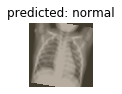

tensor([1, 0, 2])
tensor([1, 0, 2])


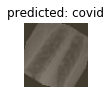

tensor([1, 0, 2])
tensor([1, 0, 2])


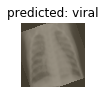

tensor([1, 1, 1])
tensor([1, 1, 1])


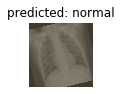

tensor([1, 1, 1])
tensor([1, 1, 1])


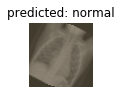

tensor([1, 1, 1])
tensor([1, 1, 1])


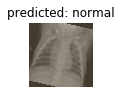

In [23]:
visualize_model(model_pr)